<a href="https://colab.research.google.com/github/abhitall/FyndMachineLearningChallange/blob/main/Fynd_Machine_Learning_Challange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing PyDrive wrapper & importing related libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authentication and creating the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
download = drive.CreateFile({'id': '1iPue6rxVwjyLqaC5Y9V_5AOISaU2qEFO'})
download.GetContentFile('data.zip')

!unzip data.zip
!rm data.zip

In [ ]:
!pip install selenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install google-images-download

    100% |████████████████████████████████| 911kB 22.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 10 not upgraded.
Need to get 64.3 MB of archives.
After this operation, 238 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 71.0.3578.98-0ubuntu0.18.04.1 [1,106 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 71.0.3578.98-0ubuntu0.18.04.1 [57.2 MB]
Get:3 http://archive.ubuntu.com/ubuntu bion

In [ ]:
# Libraries import

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, random, requests, threading, shutil, string

from imutils import build_montages, paths
from google_images_download import google_images_download
from skimage import io
from PIL import ImageFile

import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from fastai import *
from fastai.vision import *

In [ ]:
# Saving dataset to a dataframe

df = pd.read_csv('https://docs.google.com/spreadsheets/d/1r0k3IHvvLZLtdOVAQwt2dwQofuC5uS_idL-sLZ3jw5c/export?gid=806989492&format=csv', header = 0, usecols =['id', 'view_1', 'view_3', 'view_4', 'view_5', 'class'])
df.rename(columns={'view_1':'right_view', 'view_3':'side_view', 'view_4':'front_back_view', 'view_5':'left_view'}, inplace=True)
print('Dataframe size = ', df.shape)
print(df.sample(5))


Dataframe size =  (2156, 6)
                                        id  \
865   6688f924e15c462b81712ae96eef8e48.jpg   
832   3f32256c03ea4ac6a346e2ed43e4ed34.jpg   
649   de4d4b88ed27470b80294019687154d7.jpg   
1210  1d33d75b6c1f48749b8176a6f9139b47.jpg   
89    cbab6339a76a49568286a2127770a0e3.jpg   

                                             right_view  \
865   https://vision-images-store.s3.amazonaws.com/i...   
832   https://vision-images-store.s3.amazonaws.com/i...   
649   https://vision-images-store.s3.amazonaws.com/i...   
1210  https://vision-images-store.s3.amazonaws.com/i...   
89    https://vision-images-store.s3.amazonaws.com/i...   

                                              side_view  \
865   https://vision-images-store.s3.amazonaws.com/i...   
832   https://vision-images-store.s3.amazonaws.com/i...   
649   https://vision-images-store.s3.amazonaws.com/i...   
1210  https://vision-images-store.s3.amazonaws.com/i...   
89    https://vision-images-store.s3.amazonaw

In [ ]:
# Decsription of dataframe

df.describe()

,id,right_view,side_view,front_back_view,left_view,class
count,2156,2156,2151,2150,2119,2156
unique,2156,2156,2151,2150,2119,6
top,ae8c723ee0a24fe3b1be0663e92c47b8.jpg,https://vision-images-store.s3.amazonaws.com/i...,https://vision-images-store.s3.amazonaws.com/i...,https://vision-images-store.s3.amazonaws.com/i...,https://vision-images-store.s3.amazonaws.com/i...,zipper
freq,1,1,1,1,1,500


In [ ]:
# Classes present in dataset

classes = df['class'].unique()
print(classes)

['zipper' 'backstrap' 'slip_on' 'lace_up' 'buckle' 'hook&look']


In [ ]:
# Number of Images per class

for cls in classes:
  n = len(df[df['class']==cls])
  print('There are {} {} in the dataset'.format(n, cls))

There are 500 zipper in the dataset
There are 335 backstrap in the dataset
There are 425 slip_on in the dataset
There are 453 lace_up in the dataset
There are 139 buckle in the dataset
There are 304 hook&look in the dataset


In [ ]:
# Creating individual dataframe for each class

classes_images_df = {}

for cls in classes:
  sub_df = df[df['class']==cls]
  sub_df.drop(['class'], axis='columns', inplace=True)
  classes_images_df[cls] = sub_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# Creating a directory for each class

for cls in classes:
  os.makedirs('data/'+cls)

In [ ]:
def thread_helper(target):
  threads = [ ]
  for cls in classes:
      t = threading.Thread(target=target, args=(cls,))
      threads.append(t)
      t.start()

  for one_thread in threads:
      one_thread.join()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def build_collage_class(cls):
  try:
    fnames = classes_images_df[cls]['id']
    classes_images_df[cls] = classes_images_df[cls].drop(['id'], axis='columns')
    classes_images_df[cls] = classes_images_df[cls].fillna(value='plain black background image.jpg')
    
    for index, row in classes_images_df[cls].iterrows():
      # initialize the list of images
      images = []
      imagePaths = list(row.dropna())

      # loop over the list of image paths
      for imagePath in imagePaths:
        # load the image and update the list of images
        image = io.imread(imagePath)
        images.append(image)

      # construct the montages for the images
      montages = build_montages(images, (224, 224), (2, 2))
      io.imsave('data/'+cls+'/'+fnames[index], montages[0])
  except Exception as err:
    print(err)
  
  return True

thread_helper(build_collage_class)

In [ ]:
# Number of images present in each class directory

classes = ['zipper', 'backstrap' ,'slip_on' ,'lace_up', 'buckle' ,'hook&look']
images_per_class = {}

for cls in classes:
  images_per_class[cls] = len(os.listdir('data/'+cls))

print(images_per_class)

{'zipper': 500, 'backstrap': 335, 'slip_on': 425, 'lace_up': 453, 'buckle': 139, 'hook&look': 304}


In [ ]:
# Web scrapping for upsampling inbalanced data 
# may cause
def image_scraper(cls):
  response = google_images_download.googleimagesdownload() 
  query = (cls + " footwear closure")
  n = 500 - images_per_class[cls]
  if n == 0:
    return
  arguments = {"keywords":query,"limit":n,"print_urls":True, "chromedriver":"/usr/bin/chromedriver", "format":"jpg"}
  response.download(arguments)
  
thread_helper(image_scraper)

In [ ]:
def randomStringDigits(stringLength=32):
    """Generate a random string of letters and digits """
    lettersAndDigits = string.ascii_letters + string.digits
    return ''.join(random.choice(lettersAndDigits) for i in range(stringLength))


In [ ]:
for cls in classes:
  path = 'downloads/' + cls + " footwear closure"
  files = os.listdir(path)
  for file in files:
      os.rename(os.path.join(path, file), os.path.join(path, randomStringDigits()+'.jpg'))

In [ ]:
for cls in classes:
  path = 'downloads/' + cls + " footwear closure/"
  dest = 'data/'+cls
  files = os.listdir(path)
  for file in files:
      shutil.move(path+file, dest)

In [ ]:
for cls in classes:
  source = 'data/' + cls
  train_path = 'training/' + cls
  os.makedirs(train_path)
  test_path = 'validation/' + cls
  os.makedirs(test_path)
  files = os.listdir(source)
  random.shuffle(files)
  for file in files[:400]:
    shutil.copy(source+'/'+file, train_path)
  for file in files[400:]:
    shutil.copy(source+'/'+file, test_path)

In [ ]:
for cls in classes:
  source = 'data/' + cls
  train_path = 'train/' + cls
  os.makedirs(train_path)
  test_path = 'valid/' + cls
  os.makedirs(test_path)
  files = os.listdir(source)
  random.shuffle(files)
  n = int(len(files)*0.8)
  for file in files[:n]:
    shutil.copy(source+'/'+file, train_path)
  for file in files[n:]:
    shutil.copy(source+'/'+file, test_path)

In [ ]:
train_datagen = ImageDataGenerator( rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, featurewise_std_normalization=True, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator( rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, featurewise_std_normalization=True, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

training_set = train_datagen.flow_from_directory('train', target_size = (224, 224),batch_size = 32,class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory('valid', target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:346: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1724 images belonging to 6 classes.
Found 432 images belonging to 6 classes.


In [ ]:
# ResNet50 model without the last classifier layers (include_top = False)
resnett50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

# Freeze the layers 
for layer in resnett50.layers[:23]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in resnett50.layers:
    print(layer, layer.trainable)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


<keras.engine.input_layer.InputLayer object at 0x7fb031f662e8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fb031f663c8> False
<keras.layers.convolutional.Conv2D object at 0x7fb031f66240> False
<keras.layers.normalization.BatchNormalization object at 0x7fb031f66550> False
<keras.layers.core.Activation object at 0x7fb031f66860> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fb03206e3c8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb032188cc0> False
<keras.layers.convolutional.Conv2D object at 0x7fb031fd3a20> False
<keras.layers.normalization.BatchNormalization object at 0x7fb031e4a588> False
<keras.layers.core.Activation object at 0x7fb031e4a550> False
<keras.layers.convolutional.Conv2D object at 0x7fb031d801d0> False
<keras.layers.normalization.BatchNormalization object at 0x7fb031e793c8> False
<keras.layers.core.Activation object at 0x7fb031e2e128> False
<keras.layers.convolutional.Conv2D object at 0x7fb031d5f4e0> False
<keras.layers.convolution

In [ ]:
model = Sequential()
model.add(resnett50)
model.add(keras.layers.Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(6, activation="softmax"))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
def plot_hist(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
model.compile(optimizer = Adam(lr=0.0000005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
try:
  history = model.fit_generator(training_set, steps_per_epoch = 9, epochs = 1000, validation_data = validation_set, validation_steps = 3)
  plot_hist(history)
finally:
  model.save('model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


9/9 [==============================] - 38s 4s/step - loss: 2.2646 - acc: 0.2118 - val_loss: 2.1026 - val_acc: 0.1667
Epoch 2/100
9/9 [==============================] - 9s 1s/step - loss: 2.0250 - acc: 0.2778 - val_loss: 2.6744 - val_acc: 0.0938
Epoch 3/100
7/9 [======================>.......] - ETA: 1s - loss: 1.9426 - acc: 0.3170

In [ ]:
for cls in classes:
  data = ImageDataBunch.from_folder(cls)
  learn = create_cnn(data, models.resnet18, metrics=error_rate)
  print(learn)
  learn.fit_one_cycle(1)
  learn.unfreeze()
  learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))
  learn.save(cls + '_model')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 84885618.95it/s]


Learner(data=ImageDataBunch;

Train: LabelList (400 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
zipper,zipper,zipper,zipper,zipper
Path: zipper;

Valid: LabelList (100 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
zipper,zipper,zipper,zipper,zipper
Path: zipper;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

epoch,train_loss,valid_loss,error_rate,time
1,0.000000,0.000000,0.000000,00:14


epoch,train_loss,valid_loss,error_rate,time
1,0.000000,0.000000,0.000000,00:12


Learner(data=ImageDataBunch;

Train: LabelList (268 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
backstrap,backstrap,backstrap,backstrap,backstrap
Path: backstrap;

Valid: LabelList (67 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
backstrap,backstrap,backstrap,backstrap,backstrap
Path: backstrap;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

epoch,train_loss,valid_loss,error_rate,time
1,0.000000,0.000000,0.000000,00:07


epoch,train_loss,valid_loss,error_rate,time
1,0.000000,0.000000,0.000000,00:07


Learner(data=ImageDataBunch;

Train: LabelList (340 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
slip_on,slip_on,slip_on,slip_on,slip_on
Path: slip_on;

Valid: LabelList (85 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
slip_on,slip_on,slip_on,slip_on,slip_on
Path: slip_on;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

epoch,train_loss,valid_loss,error_rate,time
1,0.000000,0.000000,0.000000,00:09


epoch,train_loss,valid_loss,error_rate,time


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

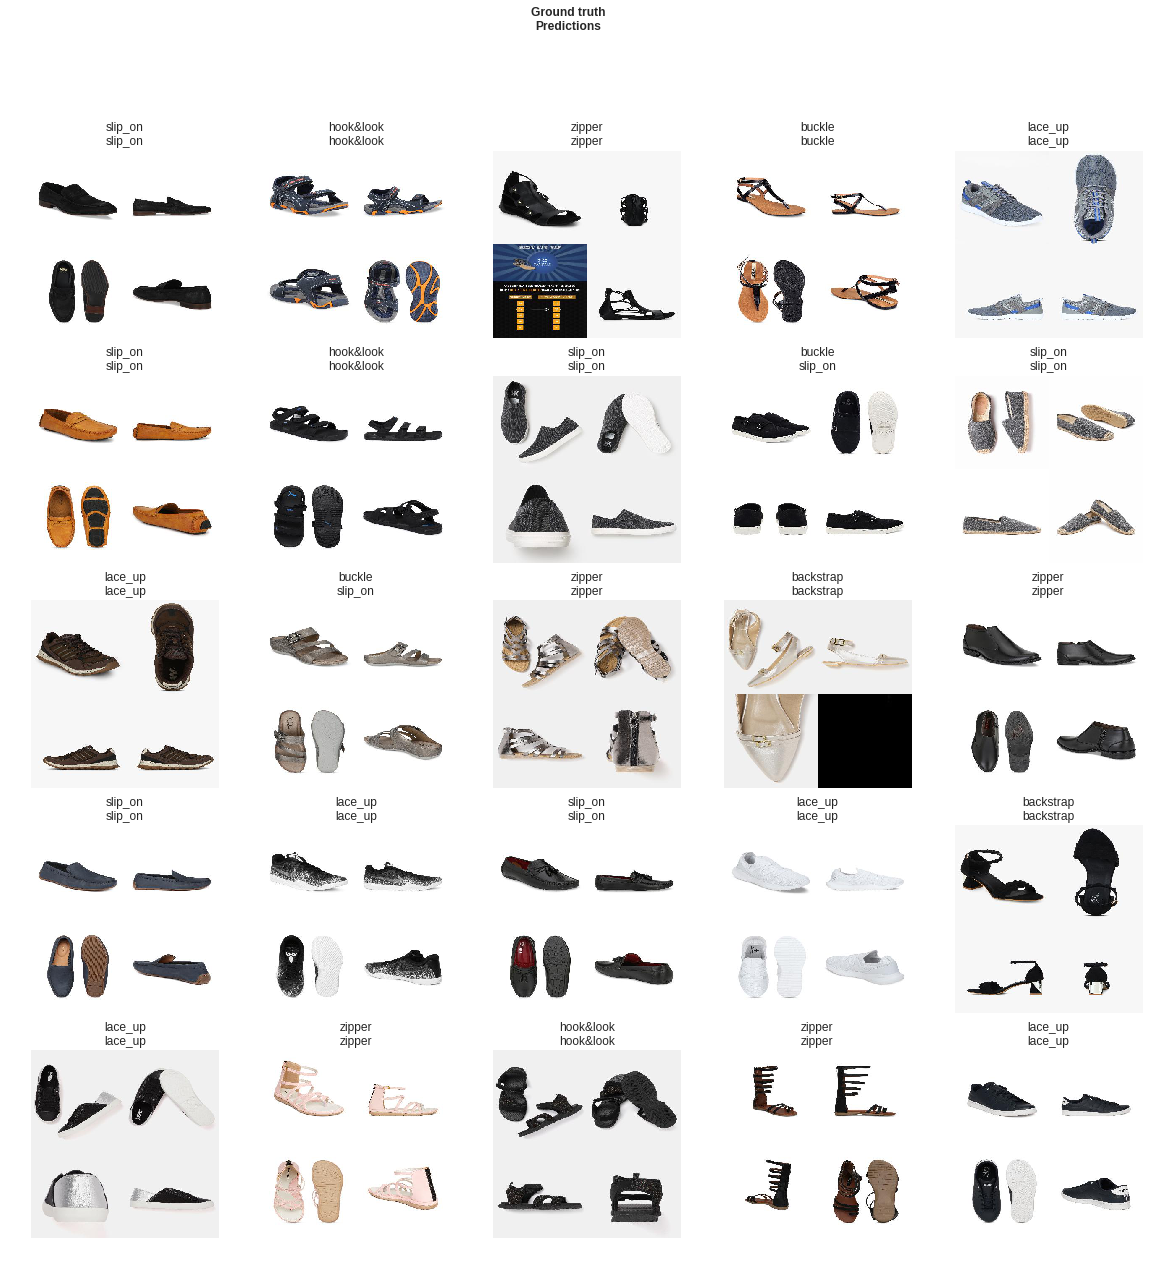

In [ ]:
learn.show_results(ds_type=DatasetType.Train)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


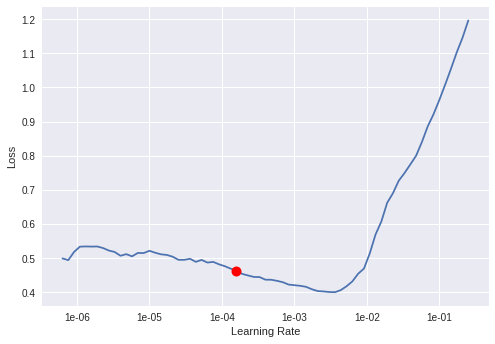

In [ ]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


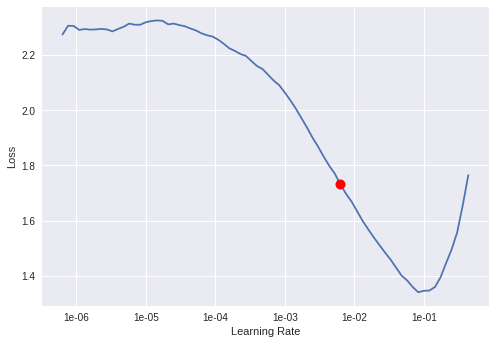

In [ ]:
data = ImageDataBunch.from_folder('')
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()